In [480]:
# pip install seaborn --user

In [481]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

# Load specific forecasting tools
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [482]:
df = pd.read_csv('../dataset/demand_dataframe.csv')[['Time' ,'COA']]
df.head()

,Time,COA
0,01-01-12 1:00,5986.0
1,01-01-12 2:00,5547.0
2,01-01-12 3:00,5233.0
3,01-01-12 4:00,5150.0
4,01-01-12 5:00,5235.0


In [483]:
df[df.Time=='01-08-15 0:00']

,Time,COA
31391,01-08-15 0:00,15277.0


In [484]:
df_temp = pd.read_csv('dataset/df_weather2012-2018.csv')[['time' , 'temperature']]

In [485]:
df_temp['Time']=df_temp.time.map(lambda x: time.strftime("%d-%m-%Y %H:%M:%S", time.localtime(x)))

In [486]:
df_test = pd.DataFrame(pd.date_range('2012-01-01 01:00:00' , '2017-12-31 23:00:00' , freq='1H') , columns=['Time'])

In [487]:
df_test.index.freq = 'H'

In [488]:
df_test.index

RangeIndex(start=0, stop=52607, step=1)

In [489]:
df_test.head()

,Time
0,2012-01-01 01:00:00
1,2012-01-01 02:00:00
2,2012-01-01 03:00:00
3,2012-01-01 04:00:00
4,2012-01-01 05:00:00


In [490]:
df_temp.head()

,time,temperature,Time
0,1325365200,14.98,01-01-2012 00:00:00
1,1325368800,13.98,01-01-2012 01:00:00
2,1325372400,11.98,01-01-2012 02:00:00
3,1325376000,11.98,01-01-2012 03:00:00
4,1325379600,11.98,01-01-2012 04:00:00


In [491]:
df_temp.drop(columns=['time'] , inplace=True)

In [492]:
df = df.set_index('Time')
df_temp = df_temp.set_index('Time')
df_test = df_test.set_index('Time')

In [493]:
df.index = pd.to_datetime(df.index, format="%d-%m-%y %H:%M" , dayfirst=True)
df_temp.index = pd.to_datetime(df_temp.index)
df_test.index = pd.to_datetime(df_test.index)

In [494]:
df.tail()

,COA
Time,
2017-12-31 19:00:00,9495.0
2017-12-31 20:00:00,9365.0
2017-12-31 21:00:00,9250.0
2017-12-31 22:00:00,8931.0
2017-12-31 23:00:00,8679.0


In [495]:
df_temp.head()

,temperature
Time,
2012-01-01 00:00:00,14.98
2012-01-01 01:00:00,13.98
2012-01-01 02:00:00,11.98
2012-01-01 03:00:00,11.98
2012-01-01 04:00:00,11.98


In [496]:
df_temp.tail()

,temperature
Time,
2018-12-31 19:00:00,16.65
2018-12-31 20:00:00,14.73
2018-12-31 21:00:00,14.76
2018-12-31 22:00:00,13.81
2018-12-31 23:00:00,12.83


In [497]:
df_t = df_temp['2012-01-01 01:00:00':'2017-12-31 23:00:00'].merge(df_test , how = 'outer' ,on = 'Time' ).sort_values('Time')

In [498]:
df_l = df['2012-01-01 01:00:00':'2017-12-31 23:00:00'].merge(df_test , how = 'outer' ,on = 'Time' ).sort_values('Time')

In [499]:
len(df_l)

52607

In [500]:
len(df_t)

52607

In [501]:
df_t.fillna(method='ffill' , inplace=True)

In [502]:
df_t.isnull().sum()

temperature    0
dtype: int64

In [503]:
df_l.index.freq = '1H'

In [504]:
df_t.index.freq = '1H'

In [505]:
df_l['temp'] = df_t.temperature.values

In [506]:
df_l = df_l.reset_index()

In [507]:
df_l.dtypes

Time    datetime64[ns]
COA            float64
temp           float64
dtype: object

In [508]:
df_l['year'] = df_l['Time'].apply(lambda x: x.year)
df_l['quarter'] = df_l['Time'].apply(lambda x: x.quarter)
df_l['month'] = df_l['Time'].apply(lambda x: x.month)
df_l['day'] = df_l['Time'].apply(lambda x: x.day)
# df_l=df_l.loc[:,['Time','COA', 'year','quarter','month','day']]
df_l.sort_values('Time', inplace=True, ascending=True)
# df = df.reset_index(drop=True)
df_l["weekday"]=df_l.apply(lambda row: row["Time"].weekday(),axis=1)
df_l["weekday"] = df_l["weekday"].astype(str)
df_l = pd.get_dummies(df_l)

In [509]:
df_l.head()

,Time,COA,temp,year,quarter,month,day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2012-01-01 01:00:00,5986.0,13.98,2012,1,1,1,0,0,0,0,0,0,1
1,2012-01-01 02:00:00,5547.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
2,2012-01-01 03:00:00,5233.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
3,2012-01-01 04:00:00,5150.0,11.98,2012,1,1,1,0,0,0,0,0,0,1
4,2012-01-01 05:00:00,5235.0,11.98,2012,1,1,1,0,0,0,0,0,0,1


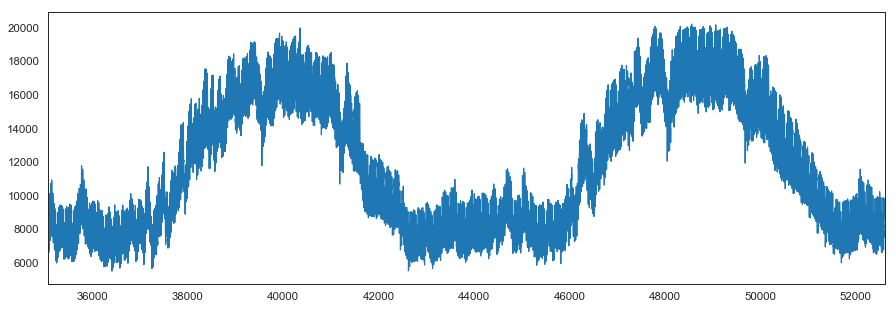

In [515]:
df_l[df_l.Time > '2016-01-01 01:00:00'].COA.plot(figsize=(15,5)).autoscale(axis='x',tight=True)

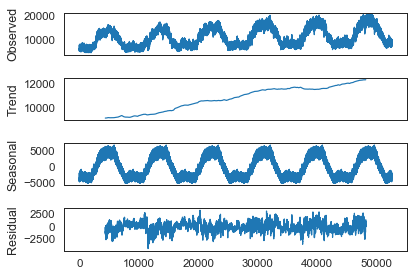

In [516]:
seasonal_decompose(df_l.COA, freq=365*24).plot();

In [517]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [518]:
adf_test(df_l.COA)

Augmented Dickey-Fuller Test: 
ADF test statistic         -3.208369
p-value                     0.019505
# lags used                58.000000
# observations          52548.000000
critical value (1%)        -3.430474
critical value (5%)        -2.861595
critical value (10%)       -2.566799
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [519]:
l_df = len(df_l[df_l.Time >= '2012-01-01 01:00:00'])

In [524]:
l_split = len(df_l[df_l.Time >= '2017-01-01 00:00:00'])

In [526]:
train = df_l.iloc[:(l_df-l_split)]
test = df_l.iloc[(l_df-l_split):]

In [527]:
l_split

8760

In [528]:
scaler = MinMaxScaler()

In [529]:
scaled_train = scaler.fit_transform(train.drop(columns=['Time']))
scaled_test = scaler.transform(test.drop(columns=['Time']))

In [180]:
n_input = 1
n_features = 15

In [178]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=50)

In [107]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add((1))
model.compile(optimizer='adam', loss='mse')

In [108]:
model.fit_generator(generator, epochs=1)

Epoch 1/1
   96/43799 [..............................] - ETA: 23:30:52 - loss: nan

KeyboardInterrupt: 

In [109]:
# CODE HERE
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [110]:
# test

In [111]:
test['Predictions'] = scaler.inverse_transform(test_predictions)

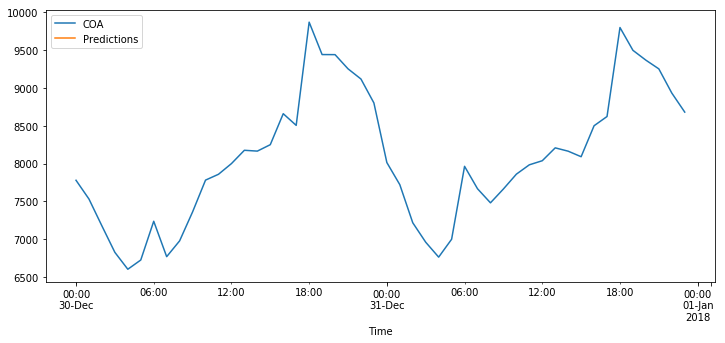

In [112]:
test.plot(figsize=(12,5))

In [113]:
rmse(test.COA,test.Predictions)

nan

In [114]:
rmse(test.COA,test.Predictions)

nan

In [115]:
test.Predictions.mean()

nan

In [116]:
test.COA.mean()

8077.457102458334

In [530]:
# train_size

In [535]:
dataset = df_l.COA.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
train_size = l_df-l_split
test_size = len(dataset) - train_size
train, test = scaler.fit_transform(dataset[0:train_size,:]), scaler.transform(dataset[train_size:len(dataset),:])

In [536]:
l_df-l_split

43847

In [537]:
train_size

43847

In [538]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [539]:
len(train)

43847

In [540]:
len(test)

8760

In [541]:
# reshape into X=t and Y=t+1
look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [542]:
X_train.shape

(43836, 10)

In [543]:
Y_train.shape

(43836,)

In [544]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [545]:
model = Sequential()
model.add(LSTM(150, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=30, batch_size=50, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=15)], verbose=1, shuffle=False)

# Training Phase
model.summary()

Train on 43836 samples, validate on 8749 samples
Epoch 1/30
43836/43836 [==============================] - 3s 77us/step - loss: 0.0022 - val_loss: 0.0313
Epoch 2/30
43836/43836 [==============================] - 3s 67us/step - loss: 0.0017 - val_loss: 0.0273
Epoch 3/30
43836/43836 [==============================] - 3s 66us/step - loss: 0.0015 - val_loss: 0.0250
Epoch 4/30
43836/43836 [==============================] - 3s 70us/step - loss: 0.0014 - val_loss: 0.0237
Epoch 5/30
43836/43836 [==============================] - 3s 67us/step - loss: 0.0013 - val_loss: 0.0231
Epoch 6/30
43836/43836 [==============================] - 3s 65us/step - loss: 0.0013 - val_loss: 0.0228
Epoch 7/30
43836/43836 [==============================] - 3s 67us/step - loss: 0.0012 - val_loss: 0.0232
Epoch 8/30
43836/43836 [==============================] - 3s 65us/step - loss: 0.0012 - val_loss: 0.0238
Epoch 9/30
43836/43836 [==============================] - 3s 65us/step - loss: 0.0012 - val_loss: 0.0248
Epoch 

In [421]:
# len(model.predict(X_test, steps=2))

21022

In [546]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 1304.3619731004655
Train Root Mean Squared Error: 1841.1292171833245
Test Mean Absolute Error: 2016.6299517902141
Test Root Mean Squared Error: 2732.258593264526


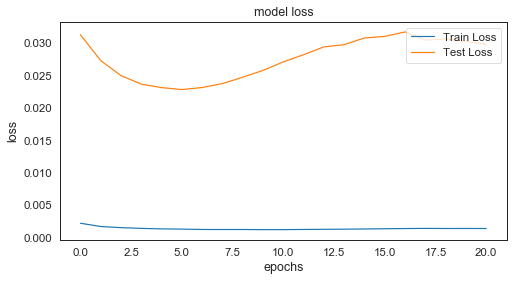

In [547]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

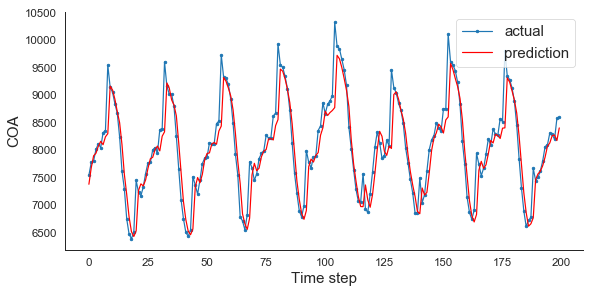

In [548]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('COA', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [549]:
df_l = df_l.set_index('Time')

In [550]:
Y_test.shape

(1, 8749)

In [551]:
test_predict.shape

(8749, 1)

In [552]:
Y_train.shape

(1, 43836)

In [553]:
-(look_back*2+2)

-22

In [554]:
tes = pd.DataFrame(Y_test.reshape(Y_test.shape[1],Y_test.shape[0]) , columns=['test'] , index= df_l.iloc[train_size+look_back:-1].index)

In [555]:
pre = pd.DataFrame(test_predict , columns=['pred'] , index= df_l.iloc[train_size+look_back:-1].index)

In [556]:
y_t = pd.DataFrame(Y_train.reshape(Y_train.shape[1],Y_train.shape[0]) , columns=['train'] , index=df_l.iloc[look_back:Y_train.shape[1]+look_back].index)

In [ ]:
# y_full = 

In [557]:
# df_l.iloc[(Y_train.shape[1]):-(look_back*2+2)].index

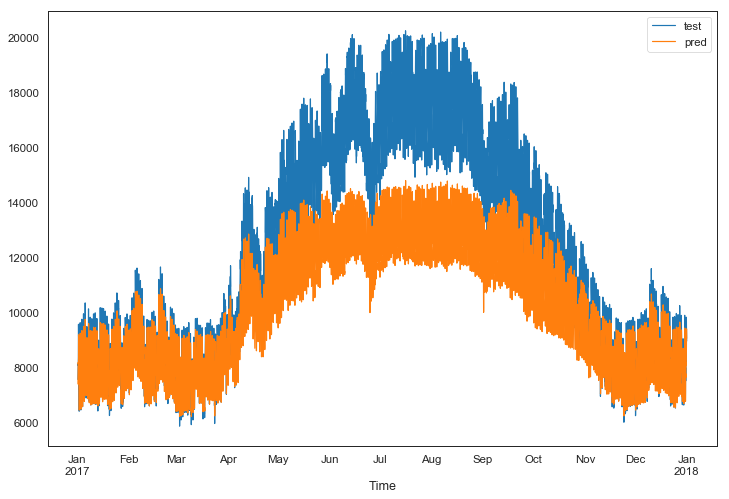

In [565]:
# df_l.COA['2017-01-01 00:00:00':].plot(figsize=(12,8) , legend=True)
# y_t.train['2012-01-01 00:00:00':'2012-02-01 00:00:00'].plot(legend=True)
tes.test['2017-01-01 00:00:00':].plot(legend=True, figsize=(12,8))
pre.pred['2017-01-01 00:00:00':].plot(legend=True)

In [561]:
rmse(tes.test , pre.pred)

2732.258593264526

In [563]:
tes.test.mean()

12331.562224197616

In [562]:
pre.pred.mean()

10372.25

In [468]:
int(len(dataset)*0.8)

42085

In [330]:
len(df_l.iloc[42074:-22].index)

10511

In [331]:
len(df_l.iloc[:42074].index)

42074